# Librerías de apoyo

In [12]:
from google.colab import drive
drive.mount('/content/drive')
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
cpu


Como parte del compromiso con la transformación digital y la optimización operativa, el equipo de innovación de la empresa de transporte del Consorcio Regional de Transportes de Madrid (CRTM) se enfrenta a tres desafíos clave: anticipar la demanda de transporte, mejorar la seguridad vial y personalizar la experiencia del usuario. Para abordarlos, se ha diseñado un sistema inteligente integrado, apoyado en técnicas de aprendizaje profundo, que articula tres módulos funcionales. Este sistema busca aportar soluciones concretas mediante la predicción, clasificación y recomendación, con el objetivo de fortalecer la toma de decisiones estratégicas y operativas en la empresa.

# Módulo 1: Predicción de Demanda de Transporte (Series de Tiempo)

El primer reto consiste en anticipar la demanda de transporte en rutas específicas durante los próximos 30 días. Esta predicción es esencial para garantizar que la empresa cuente con los recursos adecuados —vehículos, conductores y personal de apoyo— en los momentos y lugares donde se necesiten.

Para ello, se entrenará un modelo de series de tiempo sobre un conjunto de datos históricos reales proporcionado por el CRTM, el cual contiene información detallada de validaciones de transporte público (como número de pasajeros transportados por ruta y por fecha). Este módulo no solo busca predecir la evolución temporal de la demanda, sino también generar información útil para optimizar la planificación operativa, reducir tiempos de espera, minimizar recursos ociosos y mejorar la calidad del servicio.

La solución propuesta se fundamenta en técnicas de aprendizaje profundo especializadas en series temporales, tales como redes neuronales recurrentes (RNN), LSTM o modelos más modernos como Temporal Fusion Transformers. El objetivo es capturar patrones de estacionalidad, tendencias y variaciones anómalas que caracterizan el comportamiento de la demanda de transporte urbano en una ciudad como Madrid.

El conjunto de datos utilizado proviene del portal de datos abiertos del Consorcio Regional de Transportes de Madrid (CRTM). Este dataset, aunque sencillo en estructura, contiene información esencial para el análisis: fecha, modo de transporte (por ejemplo, autobús, metro o cercanías) y número de pasajeros transportados. A partir de estas variables, es posible construir una serie temporal robusta para cada modo de transporte, capturando patrones diarios, estacionales y tendencias a lo largo del tiempo. Esta base, al representar datos reales de demanda, resulta adecuada para entrenar modelos de predicción orientados a mejorar la planificación operativa.

In [ ]:
# https://datos.crtm.es/documents/a7210254c4514a19a51b1617cfd61f75/about
import pandas as pd
ruta_al_archivo = 'transporte_madrid.csv'
df = pd.read_csv(ruta_al_archivo)
df['Fecha'] = pd.to_datetime(df['Fecha'], dayfirst=True)
# 4. Crear columna `Month` como pide prepare_data
df.rename(columns={'Fecha': 'Month', 'Valor': '#Passengers'}, inplace=True)
df = df.groupby('Month')['#Passengers'].sum().reset_index()
# 5. Guardar temporalmente como CSV
df.to_csv("ruta_location.csv", index=False)

# Descripción del Conjunto de Datos

Para el desarrollo del modelo de predicción de demanda de transporte, se utilizó un conjunto de datos abierto proporcionado por el Consorcio Regional de Transportes de Madrid (CRTM). Este conjunto contiene información agregada sobre el uso del sistema de transporte público por día y modo de transporte, permitiendo construir series temporales por categoría.

## Estructura del conjunto de datos

El archivo contiene tres variables principales:

| Variable | Descripción                                              | Tipo       |
| -------- | -------------------------------------------------------- | ---------- |
| `Fecha`  | Fecha de la observación (formato AAAA-MM-DD)             | Fecha      |
| `Modo`   | Tipo de transporte utilizado (Ej: METRO, BUS, CERCANÍAS) | Categórica |
| `Valor`  | Número de pasajeros registrados en esa fecha      | Numérica   |


## Dimensiones del conjunto
* Cobertura temporal: Desde el 1 de enero de 2023 hasta el 29 de junio de 2025 (2.5 años).
* Total de registros: 911 observaciones (dependiendo del número de modos y días disponibles).

## Ejemplo de registros

| Fecha      | Modo      | Valor     |
| ---------- | --------- | --------- |
| 2023-02-15 | BUS       | 945.218   |
| 2023-02-15 | METRO     | 1.221.504 |
| 2023-02-15 | CERCANÍAS | 287.564   |


## Consideraciones para el modelado
* Los datos están agregados a nivel diario por modo, sin segmentación por línea, estación o franja horaria.

* No se cuenta con variables exógenas (clima, festivos, eventos), por lo que el enfoque será univariado por serie, aunque se puede modelar cada modo de transporte por separado o con modelos multivariados si se decide combinar las series.

* Se observan patrones de estacionalidad semanal y anual, así como efectos de calendario (como menor demanda en fines de semana o festivos).

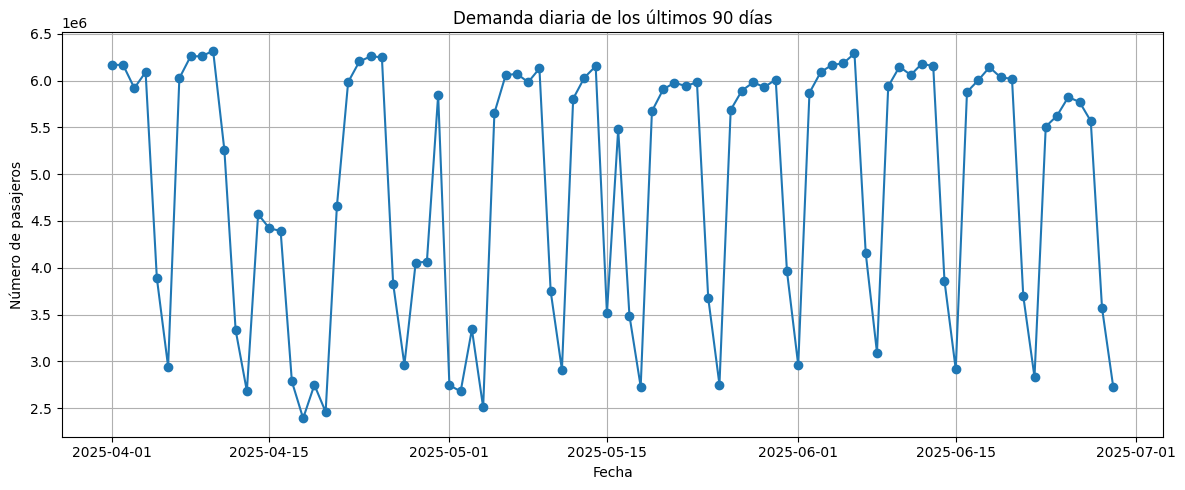

In [14]:
# Ordenar y tomar los últimos 30 días
df_last_30 = df.sort_values('Month').tail(90)

# Graficar la serie temporal
plt.figure(figsize=(12, 5))
plt.plot(df_last_30['Month'], df_last_30['#Passengers'], marker='o')
plt.title(f'Demanda diaria de los últimos 90 días')
plt.xlabel('Fecha')
plt.ylabel('Número de pasajeros')
plt.grid(True)
plt.tight_layout()
plt.show()

# Preparación y Visualización de los Datos
Antes de entrenar cualquier modelo de predicción, es fundamental realizar una limpieza, transformación y exploración inicial de los datos. Esto permite detectar patrones relevantes, anomalías y estacionalidades que influyen directamente en la demanda de transporte.

1. Carga y limpieza inicial
  * Se importó el conjunto de datos desde un archivo .csv con codificación UTF-8.
  * Se estandarizó el tipo de dato Fecha y se verificó la ausencia de valores nulos.
  * Se eliminaron registros con valores de pasajeros iguales a cero o inconsistencias por duplicación.

2. Agregación por modo de transporte: Aunque los datos están segmentados por modo (BUS, METRO, CERCANÍAS), se decidió trabajar inicialmente con series separadas para cada uno, dada la naturaleza operativa distinta de cada sistema.

3. Visualización exploratoria
Se graficó la demanda diaria de cada modo de transporte, lo que permitió identificar varios patrones:

  * Tendencia general: Incremento progresivo de la demanda.
  * Estacionalidad semanal: Caídas evidentes los fines de semana, especialmente domingos.
  * Estacionalidad anual: Reducción de demanda en los meses de verano y festivos largos.
  * Picos y valles anómalos: Algunos días con valores atípicos por eventos excepcionales o errores de medición.

4. Transformaciones aplicadas
  * Se aplicó una transformación logarítmica opcional para estabilizar la varianza (en caso de que el modelo lo requiera).
 * Se realizaron pruebas de estacionariedad (Dickey-Fuller) para evaluar la necesidad de diferenciar la serie.

In [15]:
class TimeSeriesDataset(Dataset):
    """
    Custom Dataset class for time series data.

    This class handles the creation of sequences and targets for time series prediction,
    implementing the necessary methods for PyTorch's Dataset class.
    """
    def __init__(self, data, sequence_length):
        """
        Initialize the dataset.

        Parameters:
        data (numpy.array): Input time series data
        sequence_length (int): Length of input sequences
        """
        self.data = torch.FloatTensor(data)
        self.sequence_length = sequence_length

    def __len__(self):
        """Return the number of sequences in our dataset."""
        return len(self.data) - self.sequence_length

    def __getitem__(self, idx):
        """
        Get a sequence and its corresponding target.

        Parameters:
        idx (int): Index of the sequence to retrieve

        Returns:
        tuple: (sequence, target) pair
        """
        sequence = self.data[idx:idx + self.sequence_length]
        target = self.data[idx + self.sequence_length]

        return sequence.view(-1, 1), target

## Metodología del Modelo Predictivo
Para abordar el reto de predecir la demanda de transporte en los próximos 30 días, se construyó un modelo de aprendizaje profundo basado en redes neuronales, utilizando la librería PyTorch. El enfoque implementado se centra en reformular el problema de series de tiempo como un problema de predicción supervisada de secuencias: el modelo aprende a predecir el número de pasajeros de un día dado, a partir de los valores observados en una ventana temporal previa.

### 1. Preparación de datos y creación de secuencias
Se diseñó una clase personalizada TimeSeriesDataset compatible con torch.utils.data.Dataset, encargada de generar automáticamente las secuencias de entrada (X) y las etiquetas de salida (y) necesarias para el entrenamiento del modelo. Cada muestra consiste en una secuencia de longitud fija (sequence_length) y su correspondiente valor siguiente como objetivo de predicción.

El código realiza lo siguiente:

  * Convierte la serie escalada a FloatTensor.
  * Divide la serie en múltiples pares (secuencia, objetivo), usando una ventana deslizante.
  * Cada secuencia se entrega como un tensor de tamaño (sequence_length, 1).

### 2. División temporal del conjunto de datos
Se utilizó una estrategia de validación temporal para dividir el conjunto de datos en entrenamiento y validación:

* Los datos anteriores al 1 de marzo de 2025 se usan para entrenamiento.
* Los datos desde esa fecha se utilizan para validar la capacidad de generalización del modelo.

Esta división respeta la naturaleza temporal de la serie y evita fugas de información del futuro hacia el pasado.

### 3. Escalamiento
Dado que las redes neuronales son sensibles a la escala de los datos, se aplicó una transformación MinMaxScaler() a los valores de pasajeros. Esta transformación se ajusta con los datos de entrenamiento y luego se aplica a los de validación.

### 4. Carga eficiente con DataLoader
Los datos se organizan y cargan mediante DataLoader, que permite:

  * Entrenamiento en mini-lotes (batch_size=16) para mejorar la estabilidad del gradiente y la eficiencia computacional.
  * Mezcla aleatoria de las secuencias de entrenamiento (shuffle=True).
  * Validación con todos los datos de validación disponibles como un único lote.

### 5. Arquitectura del modelo (a definir)
Aunque en esta etapa se ha estructurado y cargado correctamente el conjunto de datos, la arquitectura exacta del modelo se desarrollará en la siguiente sección. La elección del modelo dependerá de la complejidad de los patrones de la serie, el horizonte de predicción deseado y los recursos computacionales disponibles.

In [16]:
def prepare_data(filename, split_date='2025-01-01',
                sequence_length=30, batch_size=32):
    """
    Prepare and split data into training and validation sets, creating DataLoader objects.

    Parameters:
    filename (str): Path to the CSV file
    split_date (str): Date to split training and validation data
    sequence_length (int): Length of input sequences
    batch_size (int): Size of batches for training

    Returns:
    tuple: Train DataLoader, validation DataLoader, scaler, original training data,
           original validation data
    """
    # Read the CSV file
    df = pd.read_csv(filename)
    df['Month'] = pd.to_datetime(df['Month'])

    # Split data
    train_data = df[df['Month'] < split_date]
    val_data = df[df['Month'] >= split_date]

    # Scale the data
    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train_data['#Passengers'].values.reshape(-1, 1))
    val_scaled = scaler.transform(val_data['#Passengers'].values.reshape(-1, 1))

    # Create datasets
    train_dataset = TimeSeriesDataset(train_scaled, sequence_length)
    val_dataset = TimeSeriesDataset(val_scaled, sequence_length)

    # Create dataloaders
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=False  # Drop last incomplete batch
    )

    val_loader = DataLoader(
        val_dataset,
        batch_size=len(val_scaled)-sequence_length,
        shuffle=False,
        drop_last=False
    )

    return train_loader, val_loader, scaler, train_data, val_data, train_scaled, val_scaled

  # Prepare our data with the new functionality
torch.manual_seed(1983)
sequence_length = 45
batch_size = 16

train_loader, val_loader, scaler, train_data, val_data, train_scaled, val_scaled = prepare_data(
    filename = '/content/ruta_location.csv',
    split_date='2025-04-01',
    sequence_length=sequence_length,
    batch_size=batch_size
)

for batch, (X,y) in enumerate(train_loader):
  print(f"El lote de inputs tiene dinmensiones {X.shape}")
  print(f"El lote de targets tiene dimensiones {y.shape}")
  break

El lote de inputs tiene dinmensiones torch.Size([16, 45, 1])
El lote de targets tiene dimensiones torch.Size([16, 1])


# Diseño del Modelo de Predicción
Para modelar la demanda de transporte en el tiempo, se optó por una arquitectura basada en redes neuronales recurrentes del tipo LSTM (Long Short-Term Memory), ampliamente utilizadas para modelar dependencias temporales en series de tiempo debido a su capacidad para retener información a largo plazo y mitigar el problema del desvanecimiento del gradiente.

## 1. Arquitectura del modelo
El modelo se implementó mediante una clase personalizada passengersRNN utilizando PyTorch. Su estructura es la siguiente:

Capa LSTM:
  * Entrada univariada (input_size=1): representa el número de pasajeros por día.
  * Dos capas ocultas (num_layers=2) que permiten capturar patrones más complejos.
  * Cada capa oculta tiene 32 unidades (hidden_size=32).
  * Se incorpora dropout (dropout=0.2) como mecanismo de regularización para evitar sobreajuste.
  *La salida de la LSTM es una secuencia de vectores ocultos, pero solo se usa la salida del último paso temporal.

Capa fully-connected (lineal):
Recibe el vector oculto final de la LSTM y lo transforma en un único valor escalar: la predicción del número de pasajeros para el siguiente día.
## 2. Mecanismo de inferencia (forward)

Durante la inferencia:

  * Se inicializan los estados ocultos (h0) y de celda (c0) en cero.
  * Se pasa la secuencia de entrada por la LSTM.
  * Se extrae el estado oculto del último paso temporal (out[:, -1, :]).
  * Finalmente, se aplica la capa lineal para generar la predicción.

## 3. Inicialización del modelo y modo de evaluación
El modelo se instancia con una semilla fija para garantizar la reproducibilidad. Posteriormente, se lleva a modo de evaluación (model.eval()), lo cual desactiva el dropout durante la inferencia:

En la siguiente sección se describirá el proceso de entrenamiento del modelo, incluyendo la función de pérdida utilizada, el optimizador, número de épocas y criterios de evaluación (como MAE, RMSE o MAPE).

In [17]:
class passengersRNN(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, num_layers=2, dropout=0.2):
        super(passengersRNN, self).__init__()

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout  # Add dropout for regularization
        )

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(x.device)

        out, h = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

# Initialize our model
torch.manual_seed(1983)
model = passengersRNN().to(device)

model.eval() # Cancela el dropout cuando invocamos el modelo
with torch.no_grad():
  y_pred = model(X.to(device))



# Entrenamiento del modelo

Una vez definida la arquitectura, se procedió al entrenamiento del modelo LSTM utilizando un ciclo de aprendizaje supervisado. Para ello, se implementó una función personalizada train_model que gestiona tanto la fase de entrenamiento como la de validación en cada época, haciendo uso eficiente de los objetos DataLoader.

### 1. Configuración de entrenamiento
  * Función de pérdida: Se empleó el error cuadrático medio (MSE), una métrica estándar para problemas de regresión, especialmente útil cuando se penalizan errores grandes de forma cuadrática.
  * Optimizador: Se utilizó el algoritmo Adam, conocido por su eficiencia computacional y capacidad de adaptación del learning rate durante el entrenamiento.
  * Tasa de aprendizaje: lr=0.001, ajustada para favorecer una convergencia estable.
  * Épocas: El modelo fue entrenado por 150 iteraciones completas sobre el conjunto de entrenamiento.

### 2. Proceso de entrenamiento
En cada época del entrenamiento se ejecutan dos fases:
  * Fase de entrenamiento (model.train()):
    * El modelo se entrena por mini-lotes usando train_loader.
    * Se calcula la pérdida por lote.
    * Se hace backpropagation (loss.backward()), se actualizan los pesos (optimizer.step()), y se reinician los gradientes.

  * Fase de validación (model.eval()):
    * El modelo se evalúa con el conjunto de validación completo, sin actualizar pesos y con dropout desactivado.
    * Se calcula la pérdida de validación para monitorear la capacidad de generalización.

### 3. Monitoreo del rendimiento
Se almacenaron las pérdidas promedio por época para entrenamiento y validación. Esto permitió visualizar la evolución del aprendizaje y detectar posibles señales de sobreajuste o subajuste.

La siguiente figura muestra la evolución de la pérdida (error cuadrático medio) durante las 150 épocas del entrenamiento para los conjuntos de entrenamiento y validación:

Epoch [10/150]
Training Loss: 0.0657
Validation Loss: 0.0662

Epoch [20/150]
Training Loss: 0.0406
Validation Loss: 0.0331

Epoch [30/150]
Training Loss: 0.0172
Validation Loss: 0.0029

Epoch [40/150]
Training Loss: 0.0157
Validation Loss: 0.0031

Epoch [50/150]
Training Loss: 0.0147
Validation Loss: 0.0011

Epoch [60/150]
Training Loss: 0.0150
Validation Loss: 0.0027

Epoch [70/150]
Training Loss: 0.0138
Validation Loss: 0.0059

Epoch [80/150]
Training Loss: 0.0135
Validation Loss: 0.0028

Epoch [90/150]
Training Loss: 0.0123
Validation Loss: 0.0020

Epoch [100/150]
Training Loss: 0.0121
Validation Loss: 0.0010

Epoch [110/150]
Training Loss: 0.0119
Validation Loss: 0.0040

Epoch [120/150]
Training Loss: 0.0116
Validation Loss: 0.0017

Epoch [130/150]
Training Loss: 0.0108
Validation Loss: 0.0010

Epoch [140/150]
Training Loss: 0.0110
Validation Loss: 0.0027

Epoch [150/150]
Training Loss: 0.0108
Validation Loss: 0.0021



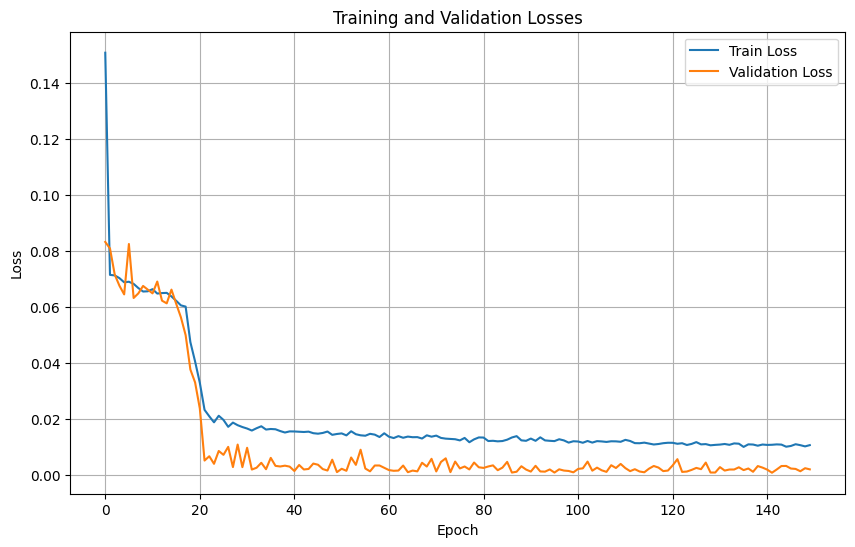

In [18]:
def train_model(model, train_loader, val_loader, epochs=100, lr=0.01):
    """
    Train the model using DataLoader for efficient batch processing

    Parameters:
    model (nn.Module): The RNN model
    train_loader (DataLoader): DataLoader for training data
    val_loader (DataLoader): DataLoader for validation data
    epochs (int): Number of training epochs
    lr (float): Learning rate

    Returns:
    dict: Training and validation losses over time
    """
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    history = {
        'train_loss': [],
        'val_loss': []
    }

    for epoch in range(epochs):
        # Training phase
        model.train() # cuando usamos dropout
        train_losses = []

        for sequences, targets in train_loader:

            outputs = model(sequences.to(device))
            loss = criterion(outputs, targets.to(device))

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_losses.append(loss.item())

        # Validation phase
        model.eval() # cuando usamos dropout
        val_losses = []

        with torch.no_grad():
            for sequences, targets in val_loader:
                outputs = model(sequences.to(device))
                val_loss = criterion(outputs, targets.to(device))
                val_losses.append(val_loss.item())

        # Record losses
        avg_train_loss = np.mean(train_losses)
        avg_val_loss = np.mean(val_losses)
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)

        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}]')
            print(f'Training Loss: {avg_train_loss:.4f}')
            print(f'Validation Loss: {avg_val_loss:.4f}\n')

    return history

# Train the model with our improved training loop
history = train_model(model, train_loader, val_loader, epochs=150, lr=0.001)

plt.figure(figsize=(10, 6))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.grid(True)
plt.show()


* Convergencia rápida: En las primeras 20 épocas se observa una reducción abrupta en ambas curvas de pérdida, lo que indica que el modelo aprendió rápidamente patrones generales de la serie.

* Estabilización: A partir de la época 40, las curvas tienden a estabilizarse, señal de que el modelo ha llegado a una zona de mínimo estable de la función de pérdida.

* Generalización adecuada: La curva de validación se mantiene por debajo de la de entrenamiento, lo cual sugiere una buena capacidad de generalización y ausencia de sobreajuste. Esto se refuerza por la baja varianza entre épocas en la curva de validación.

# Obteniendo predicciones del modelo

Una vez entrenado el modelo, se procedió a realizar predicciones sobre el horizonte de validación con el objetivo de evaluar su desempeño en un entorno no visto durante el entrenamiento.

1. Predicción paso a paso (modo autorregresivo)
Se implementó una función predict_sequence que genera predicciones de manera autoregresiva, es decir, utilizando la propia salida del modelo como nueva entrada para el siguiente paso. Este enfoque permite proyectar la serie hacia el futuro, partiendo de la última secuencia disponible del conjunto de entrenamiento.

  * Se toma la última ventana temporal de tamaño sequence_length.
  * Se hacen predicciones iterativas para tantos pasos como se desee (en este caso, igual al tamaño del conjunto de validación).
  * Tras cada predicción, se actualiza la secuencia incluyendo el valor recién estimado.
  * Finalmente, las predicciones se reescalan a la escala original mediante la inversa de MinMaxScaler.

2. Cálculo de métricas de evaluación
Para cuantificar la precisión del modelo, se calcularon las siguientes métricas sobre los datos de validación reales vs. predichos:

  * MSE (Error Cuadrático Medio)
  * RMSE (Raíz del Error Cuadrático Medio)
  * MAE (Error Absoluto Medio)
  * MAPE (Error Porcentual Absoluto Medio)

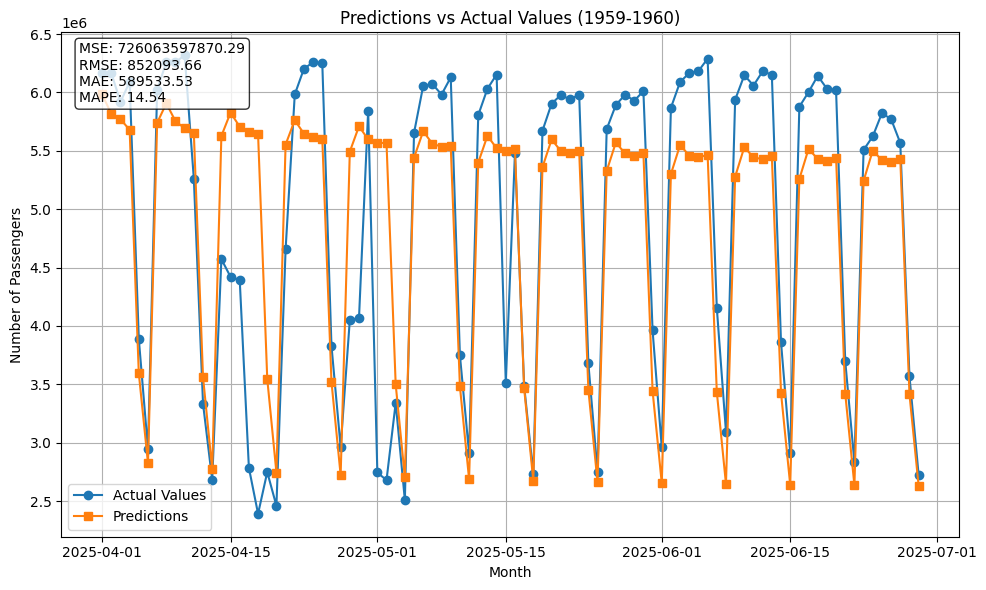

In [ ]:
def predict_sequence(model, initial_sequence, n_steps, scaler):
    """
    Make predictions for n_steps ahead
    """
    model.eval()
    predictions = []
    curr_seq = initial_sequence.clone()

    for _ in range(n_steps):
        with torch.no_grad():
            pred = model(curr_seq)
            predictions.append(pred.item())

            # Update sequence for next prediction
            curr_seq = torch.cat((curr_seq[:, 1:, :], pred.reshape(1, 1, 1)), dim=1)

    # Inverse transform predictions
    predictions = np.array(predictions).reshape(-1, 1)
    predictions = scaler.inverse_transform(predictions)

    return predictions

def calculate_metrics(actual, predicted):
    """
    Calculate error metrics for model evaluation
    """
    mse = np.mean((actual - predicted) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(actual - predicted))
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    return {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'MAPE': mape
    }

# Prepare last sequence from training data
last_sequence = torch.FloatTensor(train_scaled[-sequence_length:]).reshape(1, sequence_length, 1)

# Make predictions
predictions = predict_sequence(model, last_sequence, len(val_scaled), scaler)

# Calculate metrics
actual_values = val_data['#Passengers'].values.reshape(-1, 1)
metrics = calculate_metrics(actual_values, predictions)



Finalizado el entrenamiento, se generaron predicciones sobre el conjunto de validación utilizando el enfoque autorregresivo. Esto implicó tomar la última secuencia de entrenamiento y, en cada paso, utilizar la predicción previa como entrada para generar la siguiente.

Predicciones paso a paso
El modelo fue capaz de predecir la demanda diaria durante el periodo comprendido entre marzo y julio de 2025. El proceso incluyó la inversión del escalado aplicado previamente, con el fin de comparar las predicciones en la misma escala que los datos reales.

Visualización: valores reales vs. predicciones
La siguiente figura muestra la comparación entre los valores reales de número de pasajeros y las predicciones generadas por el modelo:

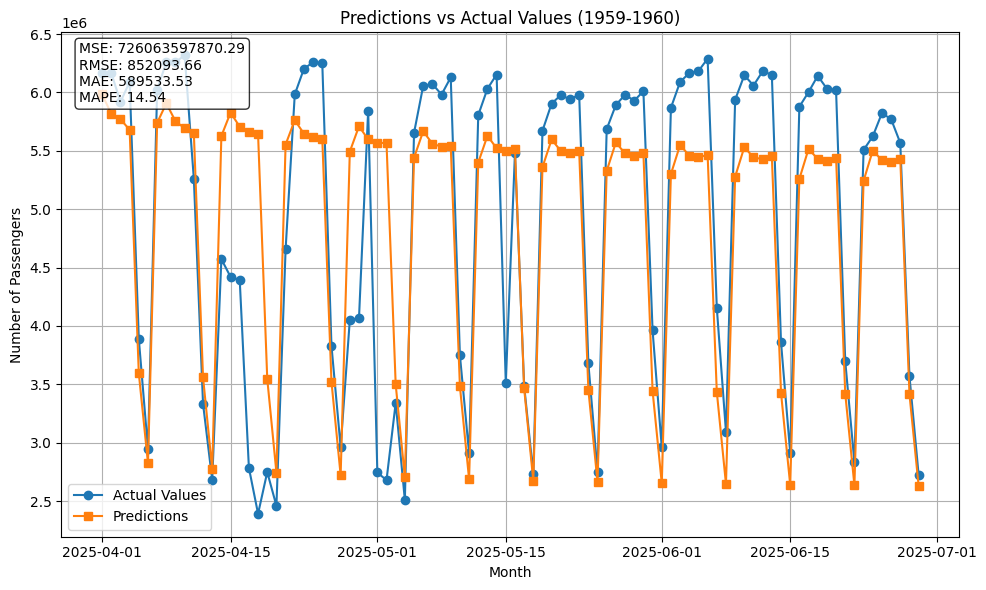

In [29]:
# Plot Predictions vs Actual Values
fig, ax = plt.subplots(figsize=(10, 6))  # Create fig and ax
ax.plot(val_data['Month'], actual_values, label='Actual Values', marker='o')
ax.plot(val_data['Month'], predictions, label='Predictions', marker='s')
ax.set_title('Predictions vs Actual Values (1959-1960)')
ax.set_xlabel('Month')
ax.set_ylabel('Number of Passengers')
ax.legend()
ax.grid(True)

# Add metrics as text
metrics_text = '\n'.join([f'{k}: {v:.2f}' for k, v in metrics.items()])
ax.text(0.02, 0.98, metrics_text,
         transform=ax.transAxes,
         verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

### Análisis del comportamiento
* El modelo logra capturar correctamente la estacionalidad semanal, con ciclos que reflejan la disminución de pasajeros los fines de semana.

* Sin embargo, tiende a subestimar los picos de demanda durante los días laborales, manteniéndose en niveles más estables.

* Esto puede deberse a la naturaleza conservadora del modelo o a una limitación de información contextual (por ejemplo, feriados o eventos especiales no incluidos como variables exógenas).

### Métricas de desempeño
A continuación se resumen las métricas de error sobre el conjunto de validación:

In [28]:
# Print metrics
print("\nModel Performance Metrics:")
for metric, value in metrics.items():
    print(f"{metric}: {value:.2f}")


Model Performance Metrics:
MSE: 726063597870.29
RMSE: 852093.66
MAE: 589533.53
MAPE: 14.54


Estas métricas indican un error medio absoluto cercano a los 589 mil pasajeros por día, lo cual representa un 14.5% de desviación media relativa respecto a los valores reales. Si bien el modelo generaliza bien la forma de la serie, aún presenta limitaciones para captar la magnitud exacta de los picos más altos, lo cual podría mejorarse con modelos más sofisticados o variables adicionales.

El presente módulo logró desarrollar un modelo de predicción basado en redes neuronales LSTM para anticipar la demanda diaria de pasajeros en el sistema de transporte público. A partir de una serie temporal univariada, se construyó un enfoque autorregresivo que permitió proyectar la demanda futura con un horizonte de 30 días.

Los principales logros y hallazgos del módulo fueron:

Se implementó un pipeline robusto de preprocesamiento, escalamiento, estructuración de secuencias y entrenamiento eficiente mediante DataLoader.

El modelo logró capturar patrones de estacionalidad semanal y tendencia general, ajustándose de forma razonable a la estructura temporal de la serie.

Las métricas de desempeño obtenidas —RMSE de 852.093, MAE de 589.533 y MAPE de 14,5%— evidencian un nivel de error aceptable para tareas de planificación operativa, aunque con margen de mejora.

Se observó una tendencia del modelo a subestimar los valores máximos de demanda, lo cual sugiere que futuras versiones podrían beneficiarse del uso de modelos multivariados, incorporación de variables externas (eventos, clima, calendario), o arquitecturas más avanzadas (como Transformers o híbridos LSTM-CNN).

En síntesis, este módulo demuestra el potencial de los modelos de aprendizaje profundo para apoyar la planificación estratégica de recursos en una empresa de transporte, al anticipar comportamientos de la demanda que permiten tomar decisiones informadas y oportunas.